In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint,solve_ivp
from tqdm import tqdm

!pip install torchdyn --quiet

In [1]:
from torchdyn.core import NeuralODE
from torchdyn.nn import DataControl, DepthCat, Augmenter, GalLinear, Fourier
from torchdyn.datasets import *
from torchdyn.utils import *

import torch
import torch.utils.data as data

import torch.nn as nn
import pytorch_lightning as pl

device = "cpu"

## DATA GENERATION

In [2]:
def Lorenz_rhs(t,x,sigma=10,b=8/3,r=28):
 F1 = sigma*(x[1]-x[0])
 F2 = r*x[0] - x[1] - x[0]*x[2]
 F3 = x[0]*x[1] - b*x[2]
 return np.array([F1,F2,F3])

In [3]:
dt = 0.01
T = 120
times = np.arange(0,T,dt)
sol = solve_ivp(Lorenz_rhs, [0,T], [1,1,1], t_eval=times)
X = sol.y

#50%
split_indx = int(len(times)*0.85)
times_train = times[:split_indx]
X_train = X[:,:(split_indx-1)]
Y_train = X[:,1:split_indx]
print(X_train.shape)


times_val = times[split_indx:]
X_val = X[:,split_indx:-1]
Y_val = X[:,split_indx+1:]
print(X_val.shape)

(3, 10199)
(3, 1799)


In [4]:
#torch conversion:
X_train = torch.Tensor(X_train.T).to(device)
Y_train = torch.Tensor(Y_train.T).to(device)

X_val = torch.Tensor(X_val.T).to(device)
Y_val = torch.Tensor(Y_val.T).to(device)

train = data.TensorDataset(X_train, Y_train)
trainloader = data.DataLoader(train, batch_size=30, shuffle=True)

In [5]:
class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.MSELoss()(y_hat, y)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [6]:
t_eval, y_hat = model(X_train[0], t_span)
y_hat = y_hat[-1] # select last point of solution trajectory
print(y_hat)
print(Y_train[0])
print(nn.MSELoss()(y_hat[0], Y_train[0]))

NameError: name 'model' is not defined

In [7]:
# vector field parametrized by a NN
f = nn.Sequential(
        nn.Linear(3, 120),
        nn.Tanh(),
        nn.Linear(120, 3))

t_span = torch.linspace(0, 1, 4)

# Neural ODE
# `interpolator` here refers to the scheme used together with `solver` to ensure estimates of the solution at all points in `t_span` are returned.
# During solution of the adjoint, cubic interpolation is used regardless of `interpolator`.
model = NeuralODE(f, sensitivity='adjoint', solver='tsit5', interpolator=None, atol=1e-3, rtol=1e-3).to(device)
model.eval()

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Neural ODE:
	- order: 1        
	- solver: Tsitouras45()
	- adjoint solver: Tsitouras45()        
	- tolerances: relative 0.001 absolute 0.001        
	- adjoint tolerances: relative 0.0001 absolute 0.0001        
	- num_parameters: 843        
	- NFE: 0.0

In [8]:
learn = Learner(t_span, model)
trainer = pl.Trainer(min_epochs=10, max_epochs=50)
trainer.fit(learn)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\olefj\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: c:\Users\olefj\Desktop\TIF360_group_15\lightning_logs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 843   
------------------------------------
843       Trainable params
0         Non-trainable params
843       Total params
0.003     Total estimated model

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\olefj\anaconda3\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


<ipython-input-14-b370019e05fe>:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  t_eval, y_hat = model(y_pred[t-1].T, t_span)


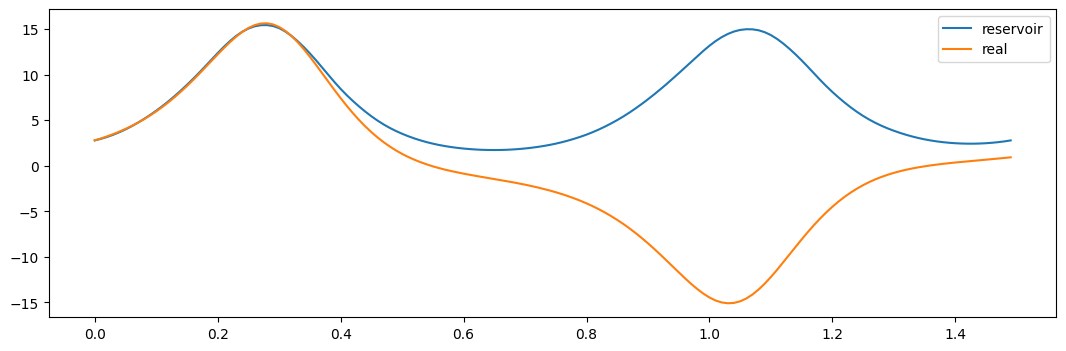

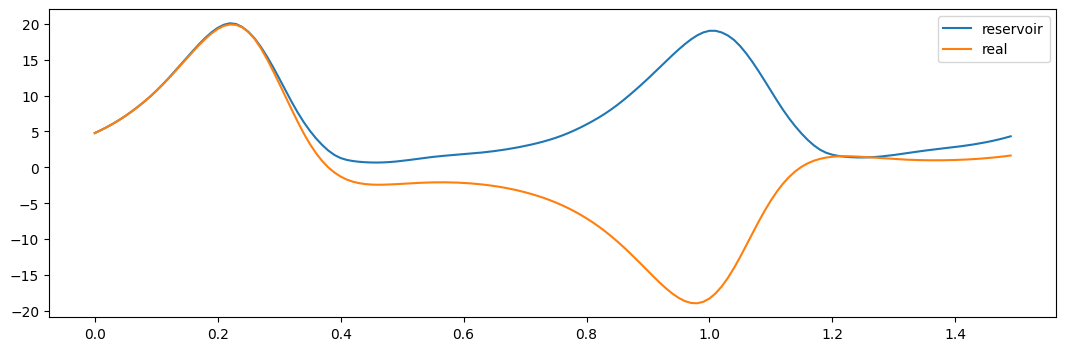

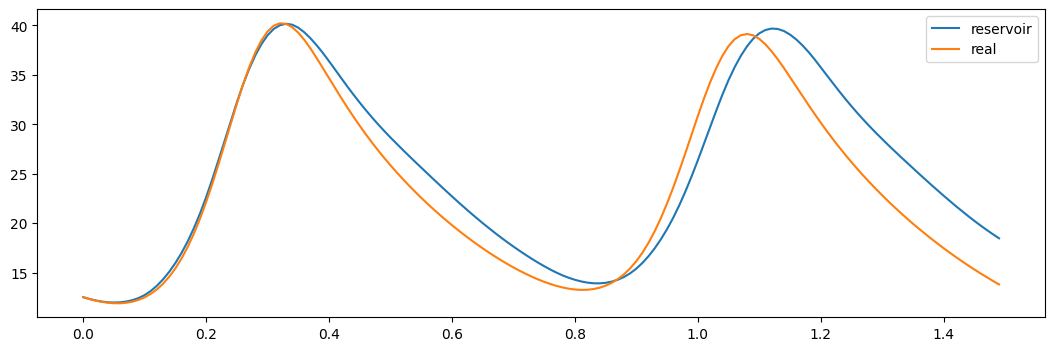

In [ ]:
y_pred = torch.zeros(X_val.shape)
y_pred[0,:] = X_val[0,:]

max_time = 1.5
n_time_step = int(max_time/dt)
for t in range(1, n_time_step):
    #y_pred[t,:]= model(y_pred[t-1].T)[1][1]
    t_eval, y_hat = model(y_pred[t-1].T, t_span)
    y_pred[t,:] = y_hat[-1]

plt.rcParams['figure.figsize'] = [13, 4]

I = np.arange(0,max_time,dt)
for d in range(3):
  plt.plot(I,y_pred[:n_time_step,d].detach().numpy(),label="reservoir")
  plt.plot(I,X_val[:n_time_step,d].detach().numpy(),label="real")
  plt.legend()
  plt.show()